In [1]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import DataCollatorForSeq2Seq
import transformers
from datasets import load_from_disk
from extended_watermark_processor import WatermarkLogitsProcessor, WatermarkDetector
from transformers import LogitsProcessorList
import matplotlib.pyplot as plt
from evaluate import load
import pandas as pd
import seaborn as sns
import torch
import datasets
rouge = load("rouge")
perplexity = load("perplexity")


/Users/rehankhalid/anaconda3/envs/dnlp1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import load_dataset

ds = load_dataset("allenai/openbookqa", "additional")

Generating test split: 100%|██████████| 500/500 [00:00<00:00, 207968.27 examples/s]


In [19]:
df = pd.DataFrame(ds["train"])
df.head()

,id,question_stem,choices,answerKey,fact1,humanScore,clarity,turkIdAnonymized
0,7-980,The sun is responsible for,"{'text': ['puppies learning new tricks', 'chil...",D,the sun is the source of energy for physical c...,1.0,2.0,b356d338b7
1,7-584,When standing miles away from Mount Rushmore,"{'text': ['the mountains seem very close', 'th...",D,"as distance to an object increases , that obje...",1.0,1.4,b356d338b7
2,7-870,When food is reduced in the stomach,"{'text': ['the mind needs time to digest', 'ta...",C,digestion is when stomach acid breaks down food,1.0,1.6,b356d338b7
3,7-321,Stars are,"{'text': ['warm lights that float', 'made out ...",C,a star is made of gases,1.0,1.6,b356d338b7
4,9-732,You can make a telescope with a,"{'text': ['straw', 'Glass', 'Candle', 'mailing...",D,Galileo Galilei made improvements to the teles...,0.8,1.0,cee82219a0


In [20]:
df["fact1"][0]

'the sun is the source of energy for physical cycles on Earth'

In [3]:
# model_name = "google/flan-t5-base"
# model_name = "google/flan-t5-large"

# Load the pre-trained model
model_name = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Put the model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


In [4]:
# Load the Datasets
cnn_path = "./cnn_dailymail_dataset"

cnn_dataset = load_from_disk(cnn_path)
cnn_test_set = cnn_dataset["test"]
cnn_train_set = cnn_dataset["train"]
cnn_val_set = cnn_dataset["validation"]

num_samples = int(len(cnn_train_set) * 0.1)  
cnn_subset_train = cnn_train_set.select(range(num_samples))

num_samples = int(len(cnn_val_set) * 0.1)  
cnn_subset_val = cnn_val_set.select(range(num_samples))


num_samples = int(len(cnn_test_set) * 0.1)  
cnn_subset_test = cnn_test_set.select(range(num_samples))


In [5]:
def preprocess_function(examples):
    """
    
    Preprocess a dataset for summarization tasks by tokenizing input texts and reference summaries i.e highlights.

    This function prepares the dataset for training or evaluation by:
    
    1. Adding a summarization prompt ("summarize: ") to the input articles.
    2. Tokenize the input articles to a fixed maximum length (512) with truncation and padding.
    3. Tokenize the reference summaries (highlights) to a fixed maximum length (200) with truncation and padding.

    Parameters:
        examples (dict): 
            1. article: Input articles for summarization.
            2. highlights: Reference highlight (ground truth) for the articles.

    Returns:
        dict: A dictionary containing tokenized inputs and labels:
            1. input_ids: Tokenized input articles with fixed padding and truncation.
            2. attention_mask: Attention masks corresponding to the input tokens.
            3. labels: Tokenized reference summaries.
    
    """
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=200, truncation=True, padding="max_length")

    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


def calculate_metrics(eval_preds):

    """
    Compute rouge score for summaries.

    Parameters:
        eval_preds (tuple): A tuple containing two elements:
            - preds:  Predicted token IDs generated by the model.
            - labels: Ground truth token IDs from the dataset.

    Returns:
        dict: A dictionary containing ROUGE scores 
            - ROUGE-1
            - ROUGE-2
            - ROUGE-L
            - ROUGE-Lsum
    """

    preds, labels = eval_preds
    
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    results = rouge.compute(predictions=decoded_preds, references= decoded_labels, use_stemmer=True)

    return results

def generate_watermarked_summaries(
    model, 
    tokenizer, 
    dataset, 
    gamma=0.25, 
    delta=2.0, 
    seeding_scheme="simple_1", 
    max_samples=100, 
    decoding_strategy='beam4', 
    batch_size=16, 
    device="cuda", 
    use_watermark=True,
):    
    """
    
    Generate watermarked summaries for a given dataset using a Seq2Seq model.

    Parameters:
        model: Fine-Tuned language model for summaries generation.
        tokenizer: Tokenizer corresponding to the fine-tuned model.
        dataset: The dataset containing input text .
        gamma: Fraction of green list tokens for watermarking (default: 0.25).
        delta: Logit boost for green list tokens (default: 2.0).
        seeding_scheme: Seeding scheme for the pseudo-random-function process (default: "simple_1").
        max_samples: Maximum number of samples to generate summaries for (default: 100).
        decoding_strategy: multinomial, beam4, beam8.
        batch size: default:16
        device: cpu or cuda
        use_watermark: use watermark logit processor

    Returns:

        watermarked_summaries: A list of watermarked summaries.
    
    """
    if decoding_strategy == 'multinomial':
        num_beams = 1
    elif decoding_strategy == 'beam4':
        num_beams = 4
    elif decoding_strategy == 'beam8':
        num_beams = 8

    early_stopping = num_beams > 1

    # Initialize the WatermarkLogitProcessor
    watermark_processor = WatermarkLogitsProcessor(
        vocab=list(tokenizer.get_vocab().values()), 
        gamma=gamma, 
        delta=delta, 
        seeding_scheme=seeding_scheme
    )

    watermarked_summaries = []
    if max_samples is None:
        max_samples = len(dataset)
        
    # Iterate through the dataset and generate summaries
    
    for i in range(0, max_samples, batch_size):
        batch = dataset.select(range(i, min(i + batch_size, max_samples)))
        input_texts = [sample["article"] for sample in batch]
        
        tokenized_input = tokenizer(
            input_texts, 
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            max_length=512
        ).to(device)

        if use_watermark == True:
            output_tokens = model.generate(
                input_ids=tokenized_input["input_ids"],
                attention_mask=tokenized_input["attention_mask"],
                logits_processor=LogitsProcessorList([watermark_processor]),
                max_new_tokens=200,
                num_beams=num_beams,
                early_stopping=early_stopping,
            )
        else:
            output_tokens = model.generate(
                input_ids=tokenized_input["input_ids"],
                attention_mask=tokenized_input["attention_mask"],
                max_new_tokens=200,
                num_beams=num_beams,
                early_stopping=early_stopping,
            )
            
        # Generate summaries from the output tokens

        batch_summaries = [tokenizer.decode(output, skip_special_tokens=True) for output in output_tokens]
        watermarked_summaries.extend(batch_summaries)

    return watermarked_summaries

def detect_watermarks(
        watermarked_summaries, 
        dataset,
        tokenizer, 
        gamma=0.25, 
        delta = 2.0,
        decoding_strategy = "beam4",
        seeding_scheme="simple_1", 
        z_threshold=4.0, 
        ignore_repeated_ngrams = False,
        max_samples = 100,
        model_device="cuda", 
        batch_size=16
    ):
    
    """
    Detect watermarks in a list of summaries using a WatermarkDetector.

    Parameters:
        watermarked_summaries: List of generated summaries to analyze.
        tokenizer: Tokenizer corresponding to the fine-tuned model.
        gamma: Fraction of green list tokens for watermarking (default: 0.25).
        delta: Logit boost for green list tokens (default: 2.0)
        decoding_strategy: multinomial, beam4, beam8.
        seeding_scheme: Seeding scheme used for watermarking (default: "simple_1").
        z_threshold: Z-score threshold for watermark detection (default: 4.0).
        ignore_repeated_ngrams: default to False
        max_samples: Maximum number of samples to generate summaries for (default: 100).
        model_device: cpu or cuda
        batch_size: default:16

    Returns:
        result: Result dataframe with water mark analysis statistics.

    """
    if max_samples is None:
        max_samples = len(dataset)

    # Initialize the WatermarkDetector
    detector = WatermarkDetector(
        vocab=list(tokenizer.get_vocab().values()),
        gamma=gamma,
        seeding_scheme=seeding_scheme,
        device=model_device,
        tokenizer=tokenizer,
        z_threshold=z_threshold,
        normalizers=[],  
        ignore_repeated_ngrams=ignore_repeated_ngrams  
    )

    detection_results = []
    for i in range(0, len(watermarked_summaries), batch_size):
        batch_summaries = watermarked_summaries[i:i + batch_size]
        batch_results = [detector.detect(summary) for summary in batch_summaries]
        detection_results.extend(batch_results)

    if decoding_strategy == 'multinomial':
        num_beams = 1
    elif decoding_strategy == 'beam4':
        num_beams = 4
    elif decoding_strategy == 'beam8':
        num_beams = 8

    # Calculating the Analysis Statistics
    total_samples = len(detection_results)
    true_positives = sum(1 for result in detection_results if result["z_score"] > z_threshold)
    false_negatives = sum(1 for result in detection_results if result["z_score"] <= z_threshold)
    false_positives = 0  
    true_negatives = total_samples - true_positives - false_negatives - false_positives
    tpr = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    fnr = false_negatives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    fpr = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0
    tnr = true_negatives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0
    z_scores = [result["z_score"] for result in detection_results]
    average_z_score = sum(z_scores) / total_samples if total_samples > 0 else 0
    reference_summaries = [sample["highlights"] for sample in dataset.select(range(max_samples))]
    rouge_scores = rouge.compute(predictions=watermarked_summaries, references=reference_summaries)
    rouge_lsum = rouge_scores["rougeLsum"]

    results = pd.DataFrame([{
    "Gamma": gamma,
    "Delta": delta,
    "Decoding": decoding_strategy,
    "Num_Beams": num_beams,
    "Z-Score Threshold" : z_threshold,
    "Average Z-Score": average_z_score,
    "True Positive Rate (TPR)": tpr,
    "False Negative Rate (FNR)": fnr,
    "False Positive Rate (FPR)": fpr,
    "True Negative Rate (TNR)": tnr,
    "Total Samples": total_samples,
    "True Positives": true_positives,
    "False Negatives": false_negatives,
    "False Positives": false_positives,
    "True Negatives": true_negatives,
    "rougeLsum" : rouge_lsum
    }])
    
    print(f"Processed Gamma={gamma}, Delta={delta}, Decoding={decoding_strategy}, Z-Threshold={z_threshold}")
    return results

In [6]:
# Preprocess the Datasets
tokenized_train_datasets = cnn_subset_train.map(preprocess_function, batched=True)
tokenized_val_datasets = cnn_subset_val.map(preprocess_function, batched=True)
tokenized_test_datasets = cnn_subset_test.map(preprocess_function, batched=True)

In [8]:
# Training Arguments for Seq2Seq Trainer
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    num_train_epochs=7,
    predict_with_generate=True, 
    fp16=False,
    logging_dir="./logs",
    load_best_model_at_end = True,
    logging_strategy="steps",
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
early_stopping_patience = 3 

# Trainer class for Training Seq2Seq models
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_val_datasets,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=calculate_metrics,
    callbacks=[transformers.EarlyStoppingCallback(early_stopping_patience)],
)

# Train the Models
trainer.train()

/home/bashir/rehan/venv/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2597412/2982146301.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.036100,2.106170,0.241735,0.094715,0.197853,0.197777
2,2.010900,2.103132,0.239823,0.093479,0.195098,0.194875
3,1.968300,2.100309,0.244024,0.096226,0.199449,0.199506
4,1.958100,2.099706,0.242363,0.094572,0.197724,0.197713
5,1.928800,2.098468,0.242099,0.094409,0.197961,0.198286
6,1.892600,2.099101,0.241577,0.094870,0.197678,0.197894
7,1.900800,2.100677,0.242345,0.095141,0.198208,0.198337


/home/bashir/rehan/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/bashir/rehan/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/bashir/rehan/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/bashir/rehan/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the 

TrainOutput(global_step=25123, training_loss=1.9682849261030262, metrics={'train_runtime': 2854.829, 'train_samples_per_second': 70.399, 'train_steps_per_second': 8.8, 'total_flos': 2.7200589234438144e+16, 'train_loss': 1.9682849261030262, 'epoch': 7.0})

In [9]:
# Save the Fine-Tuned Model to trained_models directory
trainer.save_model("./trained_models")  
tokenizer.save_pretrained("./trained_models")

('./trained_models/tokenizer_config.json',
 './trained_models/special_tokens_map.json',
 './trained_models/spiece.model',
 './trained_models/added_tokens.json',
 './trained_models/tokenizer.json')

In [7]:
def run_detection_pipeline(
    dataset,
    gamma,
    delta,
    decoding_strategy,
    device,
    seeding_scheme = "simple_1",  
    max_samples= None,
    batch_size=32,
    use_watermark=True,
    ignore_repeated_ngrams = False,
    fine_tuned_model_path = "./trained_models"      

):
    
    model = AutoModelForSeq2SeqLM.from_pretrained(fine_tuned_model_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(fine_tuned_model_path)

    watermarked_summaries = generate_watermarked_summaries(
        model,
        tokenizer,
        dataset,
        gamma,
        delta,
        seeding_scheme,
        max_samples,
        decoding_strategy,
        batch_size,  
        device,
        use_watermark
    )
    
    final_results_df = pd.DataFrame()
    for z_score in [4.0, 5.0]:
        detection_results = detect_watermarks(
            watermarked_summaries,
            dataset,
            tokenizer,
            gamma,
            delta,
            decoding_strategy,
            seeding_scheme,
            z_score,
            ignore_repeated_ngrams,
            max_samples,
            device,
            batch_size
        )
        final_results_df = pd.concat([final_results_df, detection_results], ignore_index=True)
        
    return final_results_df


In [8]:
# Run watermark detection pipeline on the sample
result = run_detection_pipeline(
    dataset = cnn_subset_test,
    gamma = 0.25,
    delta = 2.0,
    decoding_strategy = "beam4",
    device = device,
    seeding_scheme = "simple_1",  
    max_samples= 64,
    batch_size=64,
    use_watermark=True,
    ignore_repeated_ngrams = False      
)
result   


Processed Gamma=0.25, Delta=2.0, Decoding=beam4, Z-Threshold=4.0
Processed Gamma=0.25, Delta=2.0, Decoding=beam4, Z-Threshold=5.0


,Gamma,Delta,Decoding,Num_Beams,Z-Score Threshold,Average Z-Score,True Positive Rate (TPR),False Negative Rate (FNR),False Positive Rate (FPR),True Negative Rate (TNR),Total Samples,True Positives,False Negatives,False Positives,True Negatives,rougeLsum
0,0.25,2.0,beam4,4,4.0,3.88805,0.468750,0.531250,0,0,64,30,34,0,0,0.246157
1,0.25,2.0,beam4,4,5.0,3.88805,0.234375,0.765625,0,0,64,15,49,0,0,0.246157


In [17]:
# Define the Process for Parallel processing
def process_combination(params):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    gamma, delta, decoding = params

    result = run_detection_pipeline(
    dataset = cnn_subset_test,
    gamma = gamma,
    delta = delta,
    decoding_strategy = decoding,
    device = device,
    seeding_scheme = "simple_1",  
    max_samples= None,
    batch_size=256,
    use_watermark=True,
    ignore_repeated_ngrams = False      
)
    
    return result

parameter_combinations = [
    (gamma, delta, decoding)
    for gamma in [0.25, 0.5, 0.75]
    for delta in [0, 1, 2, 5, 10]
    for decoding in ["multinomial", "beam4", "beam8"]
]

final_results_df = pd.DataFrame()

for params in parameter_combinations:
    results = process_combination(params)
    final_results_df = pd.concat([final_results_df, results], ignore_index=True)

final_results_df.to_csv("sequential_watermark_detection_results.csv", index=False)
print("Results saved to 'sequential_watermark_detection_results.csv.....'")


Processed Gamma=0.25, Delta=0, Decoding=multinomial, Z-Threshold=4.0
Processed Gamma=0.25, Delta=0, Decoding=multinomial, Z-Threshold=5.0
Processed Gamma=0.25, Delta=0, Decoding=beam4, Z-Threshold=4.0
Processed Gamma=0.25, Delta=0, Decoding=beam4, Z-Threshold=5.0
Processed Gamma=0.25, Delta=0, Decoding=beam8, Z-Threshold=4.0
Processed Gamma=0.25, Delta=0, Decoding=beam8, Z-Threshold=5.0
Processed Gamma=0.25, Delta=1, Decoding=multinomial, Z-Threshold=4.0
Processed Gamma=0.25, Delta=1, Decoding=multinomial, Z-Threshold=5.0
Processed Gamma=0.25, Delta=1, Decoding=beam4, Z-Threshold=4.0
Processed Gamma=0.25, Delta=1, Decoding=beam4, Z-Threshold=5.0
Processed Gamma=0.25, Delta=1, Decoding=beam8, Z-Threshold=4.0
Processed Gamma=0.25, Delta=1, Decoding=beam8, Z-Threshold=5.0
Processed Gamma=0.25, Delta=2, Decoding=multinomial, Z-Threshold=4.0
Processed Gamma=0.25, Delta=2, Decoding=multinomial, Z-Threshold=5.0
Processed Gamma=0.25, Delta=2, Decoding=beam4, Z-Threshold=4.0
Processed Gamma=0.2

In [9]:
results_df = pd.read_csv("sequential_watermark_detection_results.csv")
results_df.head()

,Gamma,Delta,Decoding,Num_Beams,Z-Score Threshold,Average Z-Score,True Positive Rate (TPR),False Negative Rate (FNR),False Positive Rate (FPR),True Negative Rate (TNR),Total Samples,True Positives,False Negatives,False Positives,True Negatives,rougeLsum
0,0.25,0,multinomial,1,4.0,0.245923,0.004352,0.995648,0,0,1149,5,1144,0,0,0.244479
1,0.25,0,multinomial,1,5.0,0.245923,0.002611,0.997389,0,0,1149,3,1146,0,0,0.244479
2,0.25,0,beam4,4,4.0,0.225861,0.000870,0.999130,0,0,1149,1,1148,0,0,0.250946
3,0.25,0,beam4,4,5.0,0.225861,0.000000,1.000000,0,0,1149,0,1149,0,0,0.250946
4,0.25,0,beam8,8,4.0,0.191774,0.003481,0.996519,0,0,1149,4,1145,0,0,0.246085


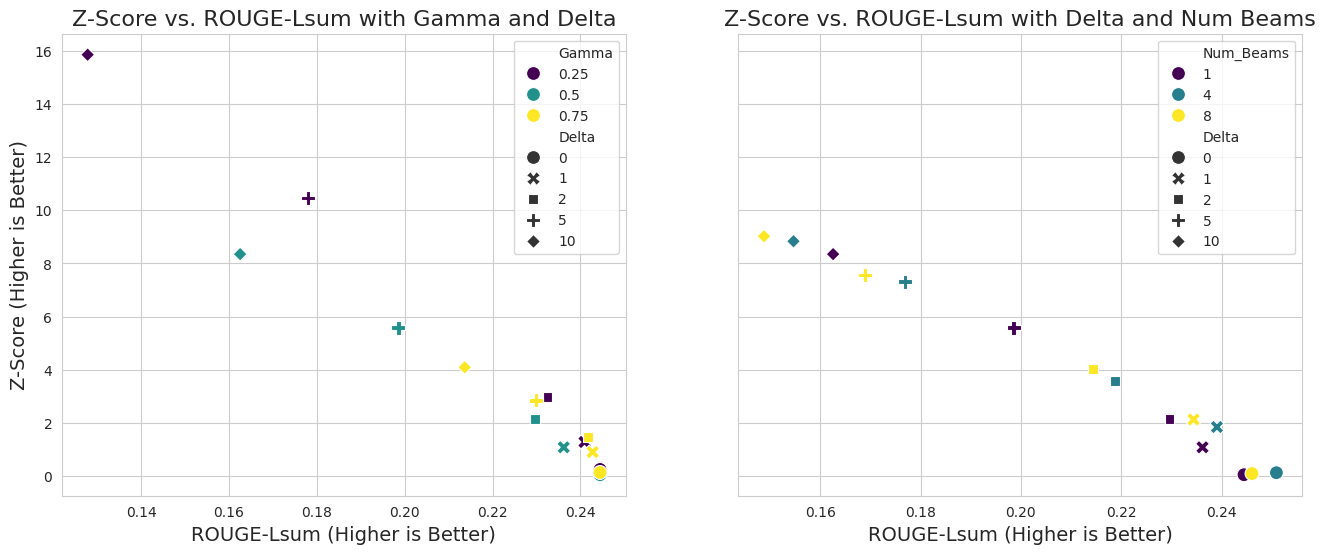

<Figure size 640x480 with 0 Axes>

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # Share Y-axis for better comparison
sns.set_style("whitegrid")

# Subplot 1: Z-Score vs. ROUGE-Lsum with Gamma and Delta
scatter1 = sns.scatterplot(
    data=results_df[(results_df["Decoding"]== "multinomial")&(results_df["Z-Score Threshold"]== 4.0)],
    x="rougeLsum",
    y="Average Z-Score",
    hue="Gamma",
    style="Delta",
    palette="viridis",
    s=100, 
    ax=axes[0]
)
axes[0].set_title("Z-Score vs. ROUGE-Lsum with Gamma and Delta", fontsize=16)
axes[0].set_xlabel("ROUGE-Lsum (Higher is Better)", fontsize=14)
axes[0].set_ylabel("Z-Score (Higher is Better)", fontsize=14)
axes[0].legend(loc="upper right", frameon=True) 

# Subplot 2: Z-Score vs. ROUGE-Lsum with Delta and Num Beams
scatter2 = sns.scatterplot(
    data=results_df[(results_df["Gamma"]== 0.5)&(results_df["Z-Score Threshold"]== 4.0)],
    x="rougeLsum",
    y="Average Z-Score",
    hue="Num_Beams",
    style="Delta",
    palette="viridis",
    s=100,  
    ax=axes[1]
)
axes[1].set_title("Z-Score vs. ROUGE-Lsum with Delta and Num Beams", fontsize=16)
axes[1].set_xlabel("ROUGE-Lsum (Higher is Better)", fontsize=14)
axes[1].set_ylabel("") 
axes[1].legend(loc="upper right", frameon=True)  

# Adjust layout
plt.show()
plt.tight_layout()

### Observations from Watermark Analysis

#### Graph 1: Z-Score vs. ROUGE-Lsum with Gamma and Delta
- Higher `Gamma` improves Z-Score (stronger watermark detection) but slightly affects ROUGE-Lsum (summary quality).
- Larger `Delta` enhances Z-Score but reduces ROUGE-Lsum at extreme values (e.g., Delta = 10).
- Moderate `Gamma` (0.5) and `Delta` (2 or 5) achieve a good trade-off between detection robustness and quality.

#### Graph 2: Z-Score vs. ROUGE-Lsum with Delta and Num Beams
- Higher beam search values (e.g., 4 or 8) improve ROUGE-Lsum without significantly affecting Z-Score.
- Similar trend—higher `Delta` boosts Z-Score but slightly reduces ROUGE-Lsum.
- For better summary quality, use higher `Num_Beams`. For stronger watermark detection, prioritize moderate `Delta` values.

- Gamma = 0.5, Delta = 2 or 5, and Num_Beams = 4 balances detection robustness and summarization quality.
- Stronger watermarks may slightly degrade summary quality, requiring careful parameter tuning based on priorities.

/tmp/ipykernel_3791075/4052410402.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_filtered['Gamma'] = results_df_filtered['Gamma'].astype(str)
/tmp/ipykernel_3791075/4052410402.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_filtered['Num_Beams'] = results_df_filtered['Num_Beams'].astype(str)


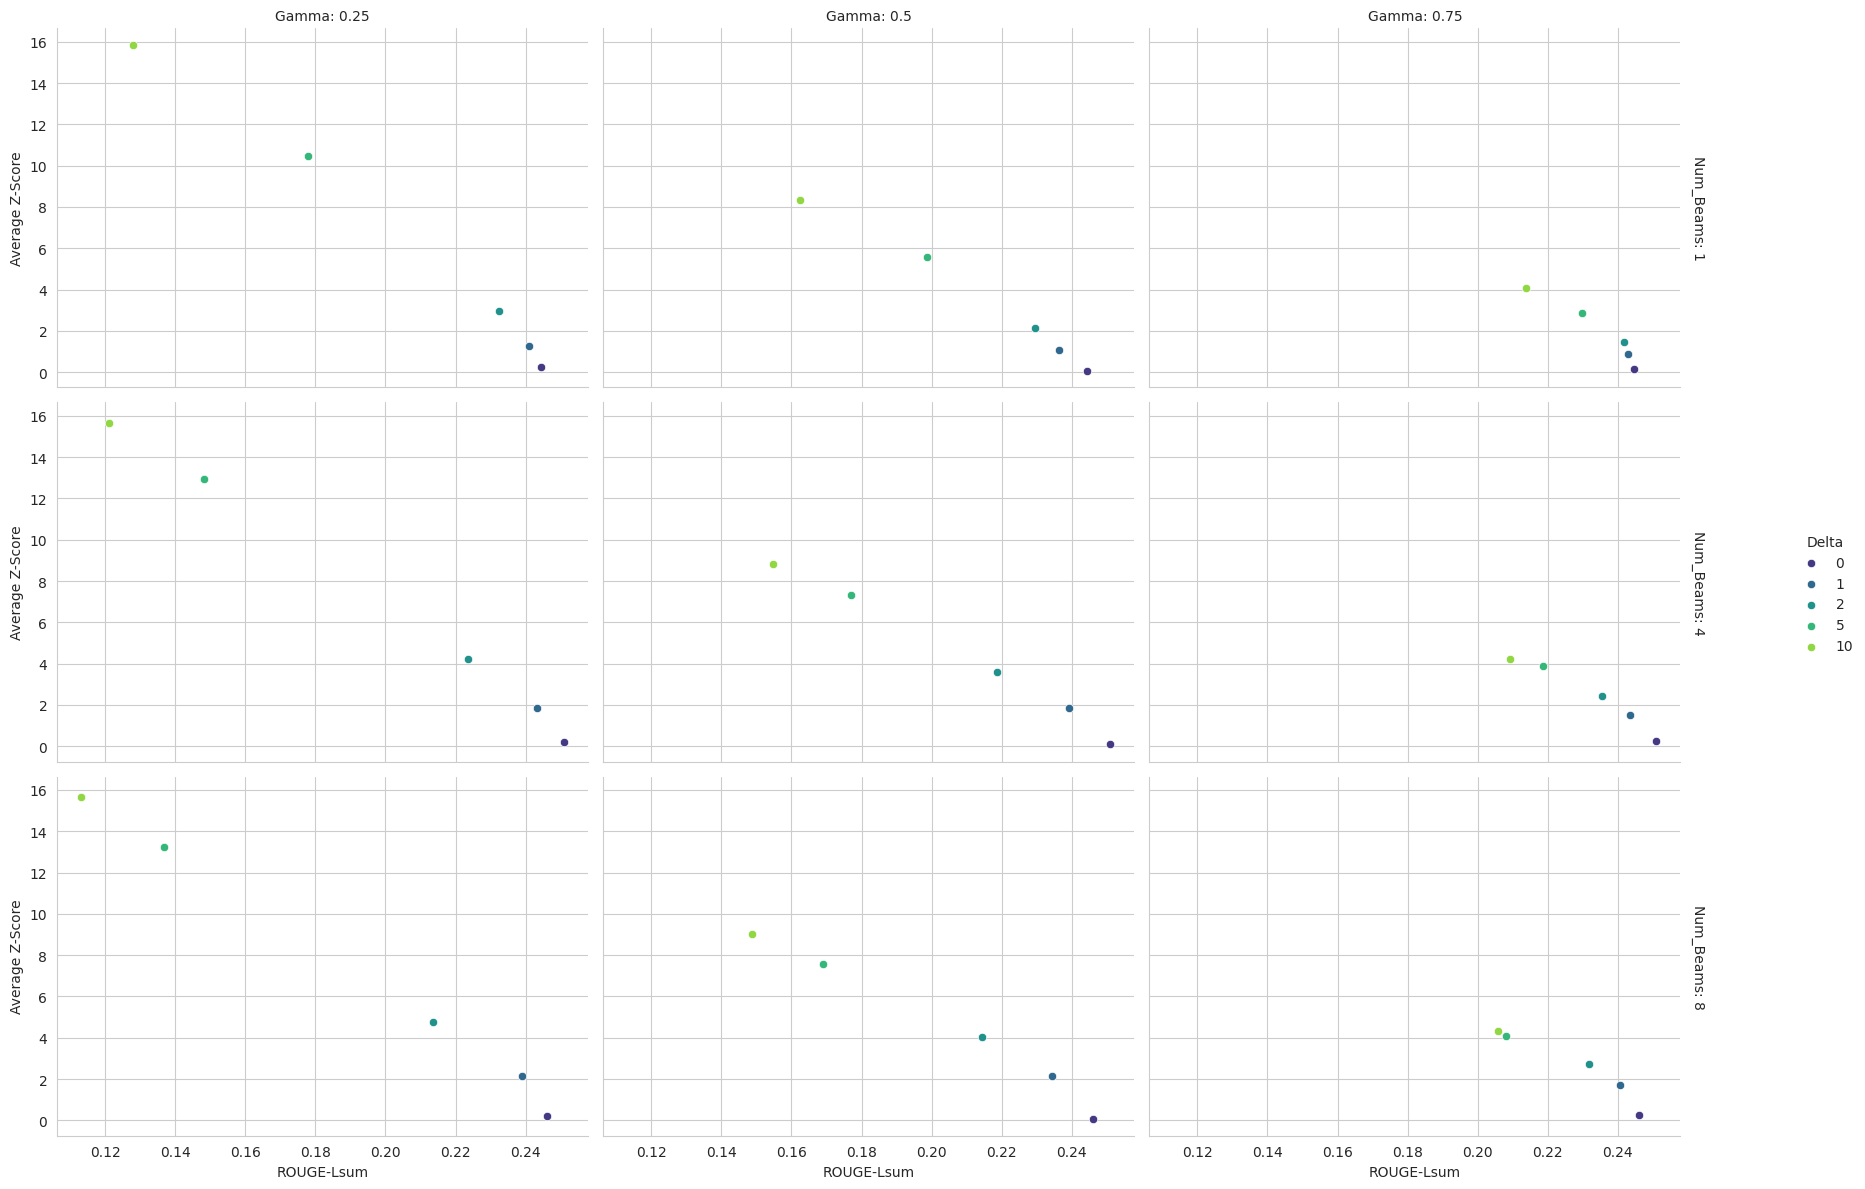

In [17]:
results_df_filtered = results_df[results_df["Z-Score Threshold"] == 4.0]



# Ensure Gamma and Delta are categorical for faceting
results_df_filtered['Gamma'] = results_df_filtered['Gamma'].astype(str)
results_df_filtered['Num_Beams'] = results_df_filtered['Num_Beams'].astype(str)

# Create the facetted scatter plot
g = sns.FacetGrid(
    results_df_filtered,
    col="Gamma",
    row="Num_Beams",
    margin_titles=True,
    height=4,
    aspect=1.5,
    hue="Delta",
    palette="viridis"
)
g.map_dataframe(sns.scatterplot, x="rougeLsum", y="Average Z-Score")

# Add legend and adjust layout
g.add_legend(title="Delta")
g.set_axis_labels("ROUGE-Lsum", "Average Z-Score")
g.set_titles(col_template="Gamma: {col_name}", row_template="Num_Beams: {row_name}")
g.tight_layout()

# Display the plot
plt.show()


### Effect of Gamma, Delta and Num_Beams on Average Z Score and Rouge 
- Higher Delta values increase the Average Z-Score, indicating stronger watermark detection. However, this robustness comes at the expense of reduced ROUGE-Lsum scores, particularly noticeable at higher Gamma values (e.g., 0.75). 
- At lower Gamma values (e.g., 0.25), the impact of Delta on both Z-Score and ROUGE-Lsum is more pronounced, allowing for better trade-offs between summary quality and watermarking effectiveness.
- Higher Num_Beams configurations (e.g., 8) lead to improved ROUGE-Lsum scores, reflecting better summary quality. However, they slightly reduce the Average Z-Score, potentially weakening watermark robustness.
- Lower Num_Beams settings (e.g., 1) amplify Z-Scores, indicating stronger watermarking but result in a noticeable drop in ROUGE-Lsum, compromising summary quality.
- A balanced configuration for practical use appears to involve moderate Delta values (e.g., 2 or 5), lower Gamma (e.g., 0.25 or 0.5), and intermediate Num_Beams (e.g., 4). This combination provides a reasonable trade-off between watermark detection robustness and summary quality.


In [43]:
sorted_data = results_df[(results_df["Delta"] != 0) & (results_df["Delta"] != 10)].sort_values(
    by=["Decoding", "Delta", "Gamma", "Z-Score Threshold"],
    ascending=[True, True, True, True]
)

sorted_data = sorted_data[[
    "Decoding","Delta", "Gamma", "Total Samples", "True Positive Rate (TPR)", "False Negative Rate (FNR)","Z-Score Threshold"
]]
reshaped_df = sorted_data.pivot(index=["Decoding", "Delta", "Gamma"], 
                       columns="Z-Score Threshold", 
                       values=[ "False Negative Rate (FNR)",  "True Positive Rate (TPR)"])
reshaped_df = reshaped_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)

reshaped_df

Z-Score Threshold                             4.0                           \
                        False Negative Rate (FNR) True Positive Rate (TPR)   
Decoding    Delta Gamma                                                      
beam4       1     0.25                   0.949521                 0.050479   
                  0.50                   0.960836                 0.039164   
                  0.75                   0.991297                 0.008703   
            2     0.25                   0.486510                 0.513490   
                  0.50                   0.656223                 0.343777   
                  0.75                   0.964317                 0.035683   
            5     0.25                   0.003481                 0.996519   
                  0.50                   0.005222                 0.994778   
                  0.75                   0.571802                 0.428198   
beam8       1     0.25                   0.922541                 0.077459   
                  0.50                   0.926023                 0.073977   
                  0.75                   0.987815                 0.012185   
            2     0.25                   0.369887                 0.630113   
                  0.50                   0.516101                 0.483899   
                  0.75                   0.926893                 0.073107   
            5     0.25                   0.000870                 0.999130   
                  0.50                   0.002611                 0.997389   
                  0.75                   0.470844                 0.529156   
multinomial 1     0.25                   0.970409                 0.029591   
                  0.50                   0.987815                 0.012185   
                  0.75                   0.996519                 0.003481   
            2     0.25                   0.726719                 0.273281   
                  0.50                   0.917319                 0.082681   
                  0.75                   0.990426                 0.009574   
            5     0.25                   0.002611                 0.997389   
                  0.50                   0.134030                 0.865970   
                  0.75                   0.881636                 0.118364   

Z-Score Threshold                             5.0                           
                        False Negative Rate (FNR) True Positive Rate (TPR)  
Decoding    Delta Gamma                                                     
beam4       1     0.25                   0.989556                 0.010444  
                  0.50                   0.986945                 0.013055  
                  0.75                   1.000000                 0.000000  
            2     0.25                   0.697998                 0.302002  
                  0.50                   0.868581                 0.131419  
                  0.75                   0.997389                 0.002611  
            5     0.25                   0.003481                 0.996519  
                  0.50                   0.022628                 0.977372  
                  0.75                   0.949521                 0.050479  
beam8       1     0.25                   0.975631                 0.024369  
                  0.50                   0.980853                 0.019147  
                  0.75                   0.998259                 0.001741  
            2     0.25                   0.601393                 0.398607  
                  0.50                   0.801567                 0.198433  
                  0.75                   0.996519                 0.003481  
            5     0.25                   0.000870                 0.999130  
                  0.50                   0.015666                 0.984334  
                  0.75                   0.926893                 0.073107  
multinomial 1     0.25                   0

### Conclusions

- Higher delta values (e.g., 5) result in significantly higher True Positive Rates (TPR) and lower False Negative Rates (FNR), indicating better watermark detectability. However, these configurations slightly reduce ROUGE-Lsum values, reflecting a trade-off between summary quality and detectability.
- Lower gamma values (e.g., 0.25) result in better detectability with higher TPR and lower FNR, especially at higher delta values.
- Beam8 decoding achieves higher TPR and lower FNR compared to multinomial and beam4. This indicates stronger watermark detectability but at the cost of reduced ROUGE-Lsum values, highlighting a trade-off in quality.
- Multinomial decoding maintains higher ROUGE-Lsum values but suffers in watermark detectability with lower TPR and higher FNR.
- Z-scores increase with higher delta values, improving watermark detectability, while ROUGE-Lsum values decline.
- Gamma's impact is consistent across decoding strategies, with lower gamma maintaining better watermark robustness (higher Z-scores).
- Use **delta = 5** and **gamma = 0.25** with **beam4** for reasonable detectability and quality trade-off.
- Opt for **beam8** if detectability is prioritized over quality.